In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf
from mne.datasets import eegbci
from mne.decoding import CSP

In [2]:
def get_data():
    path = "dataset\\eegbci"
        
    tmin, tmax = -0.5, 4.
    event_id = dict(hands=2, feet=3)
    subject = 1
    runs = [6, 10, 14]  # motor imagery: hands vs feet

    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

    events, _ = events_from_annotations(raw)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)
    epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, 2] - 2
    return epochs.get_data()[:, :, :256], labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

Extracting EDF parameters from c:\Users\asus\Desktop\Motorimagery_for_gamification\dataset\eegbci\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., Cz.., C2.., C4.., C6.., Cp5., Cp3., Cp1., Cpz., Cp2., Cp4., Cp6., Fp1., Fpz., Fp2., Af7., Af3., Afz., Af4., Af8., F7.., F5.., F3.., F1.., Fz.., F2.., F4.., F6.., F8.., Ft7., Ft8., T7.., T8.., T9.., T10., Tp7., Tp8., P7.., P5.., P3.., P1.., Pz.., P2.., P4.., P6.., P8.., Po7., Po3., Poz., Po4., Po8., O1.., Oz.., O2.., Iz..
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\asus\Desktop\Motorimagery_for_gamification\dataset\eegbci\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Could not determine channel typ

In [3]:
# 280 events
# 22 channel
# 256 Time

print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info)


(45, 64, 256)
(45,)
64
[1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 1 0 1]
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>


<Epochs |  45 events (all good), 1 - 4 sec, baseline off, ~10.6 MB, data loaded,
 'feet': 24
 'hands': 21>
Using matplotlib as 2D backend.


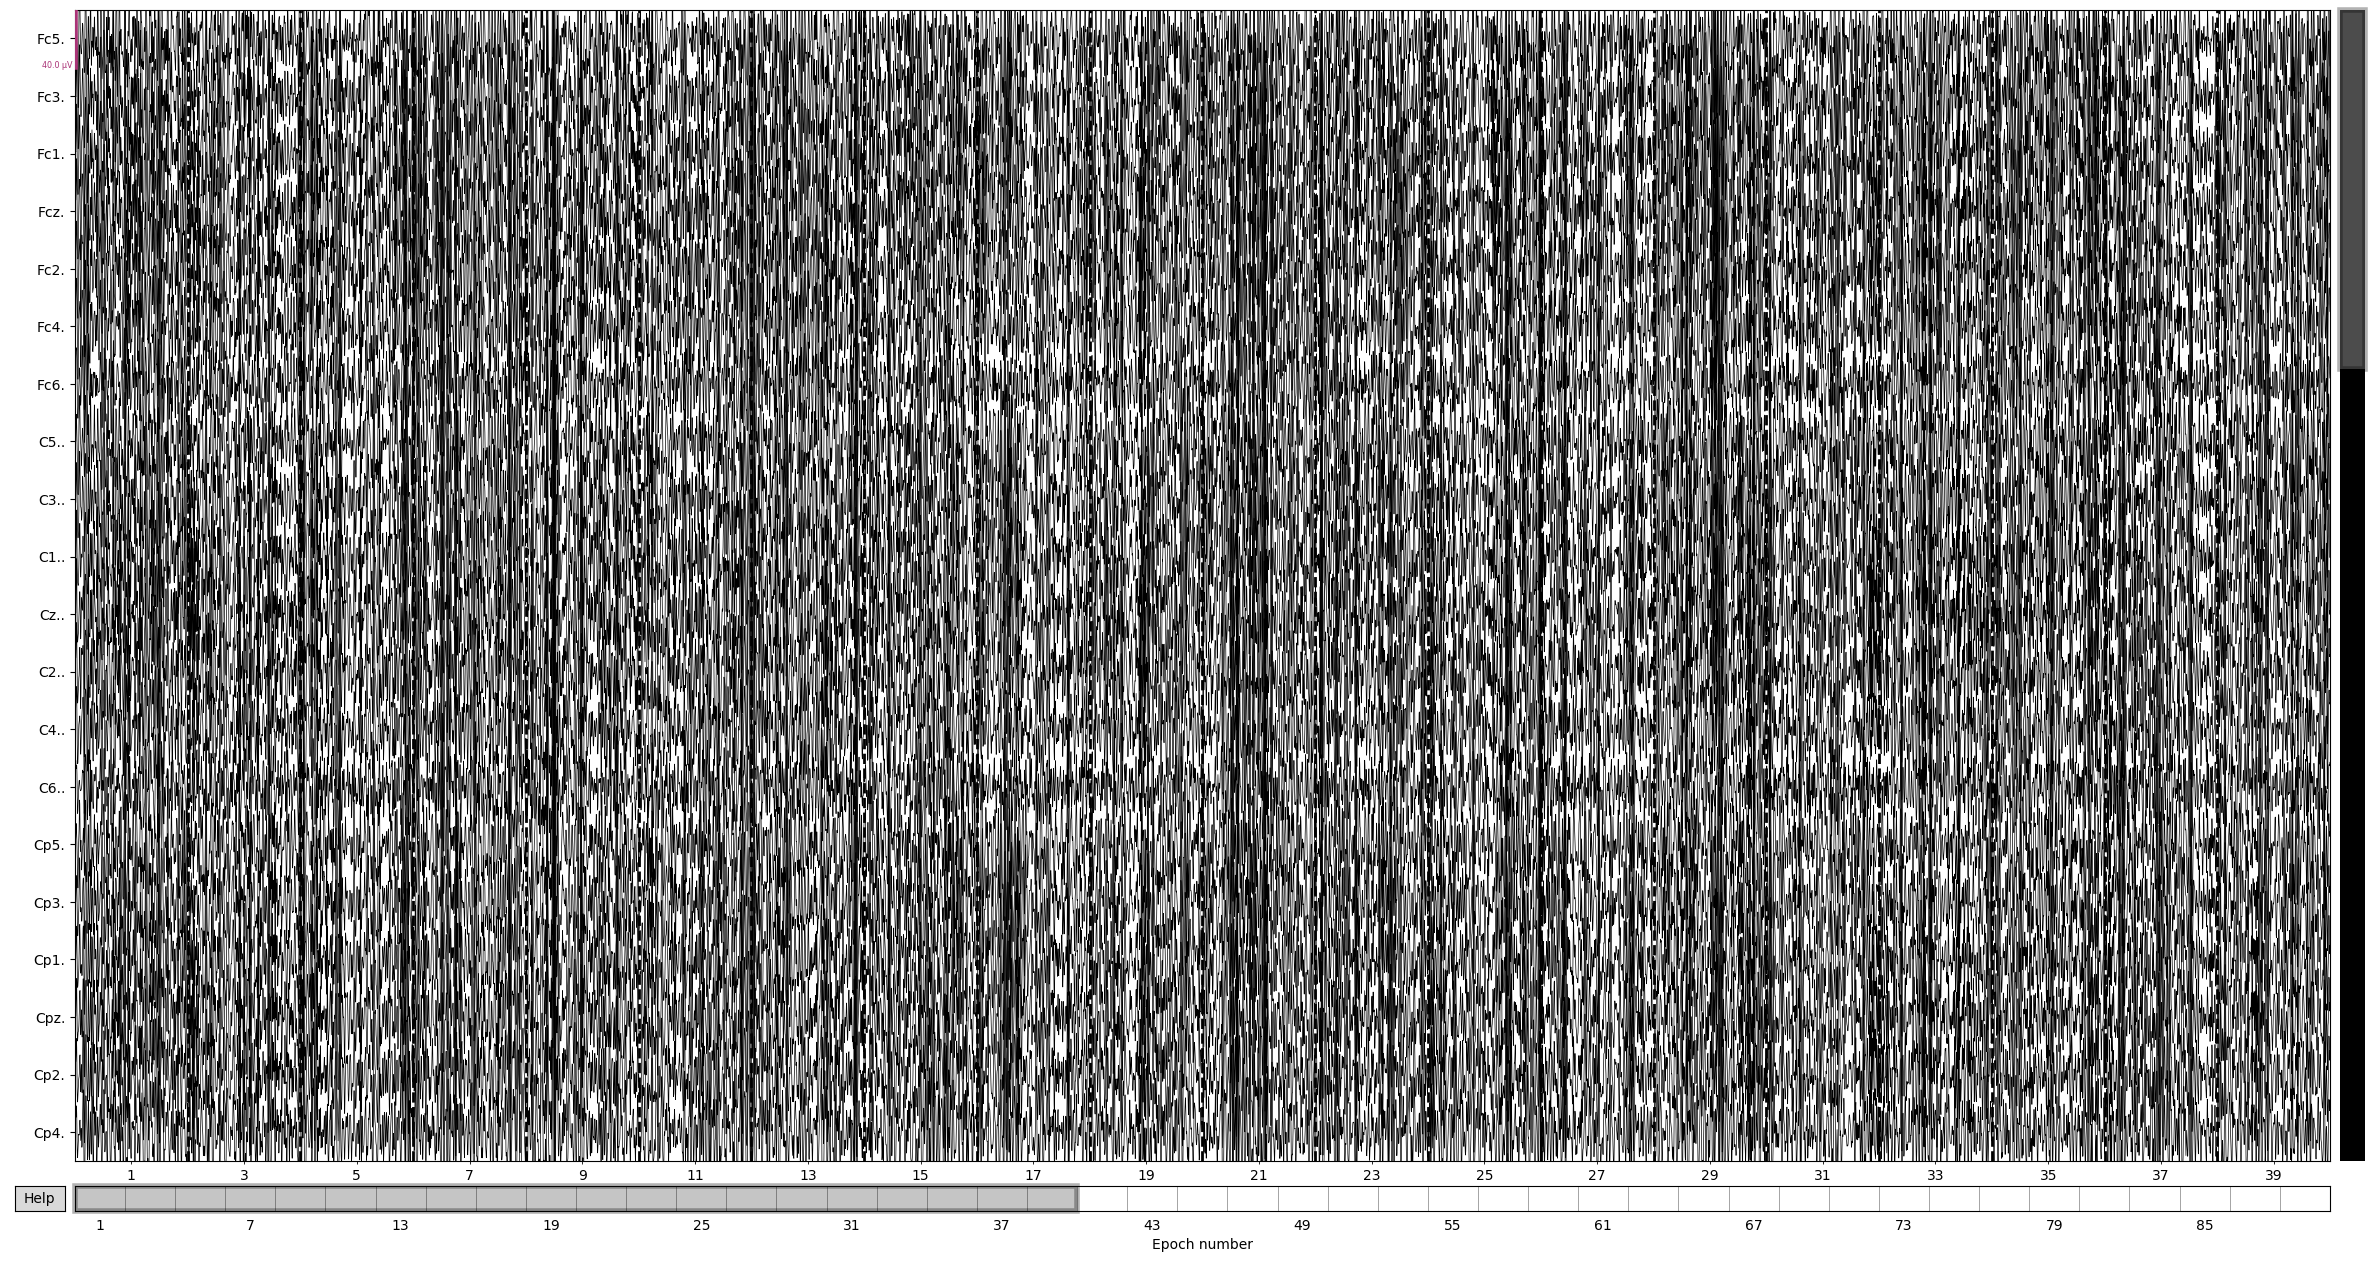

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-4-c026fcb3c4d9>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs1.plot_psd(fmax=50)


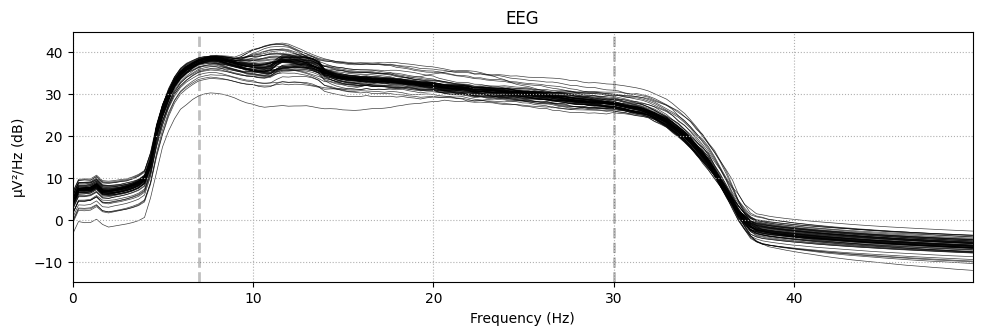

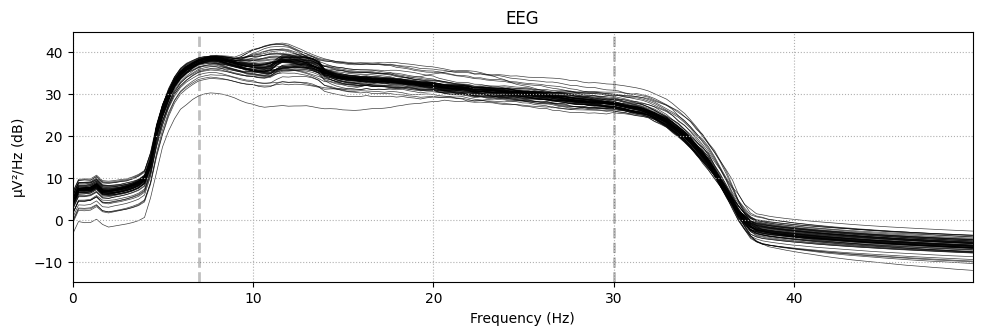

In [4]:
print(epochs1)
epochs1.plot()
epochs1.plot_psd(fmax=50)

In [5]:
def amplitude(x):
    """Data augmentation for adding noise to amplitude of sepctral image
    1 electrode คือ การดึงค่าคลื่นจาก electrode นั้นมา ซึ้่ง electrode นั้นคือ fc fz c4 c3 ประมาณนี้
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        reconstructed new time series from inverse STFT
    """
    print("Hello")



In [6]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import RandomSampler  
from torch.utils.data import SequentialSampler  

from common import EpochsDataset  

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)
train_idx, test_idx = next(cv_split)


def scale(X):
    """Standard scaling of data along the last dimention.
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    return X / 2e-5

dataset = EpochsDataset(epochs_data, labels, transform=scale)

ds_train, ds_valid = Subset(dataset, train_idx), Subset(dataset, test_idx)

batch_size_train = len(ds_train)
batch_size_valid = len(ds_valid)
sampler_train = RandomSampler(ds_train)
sampler_valid = SequentialSampler(ds_valid)

# create loaders
num_workers = 0
loader_train = \
    DataLoader(ds_train, batch_size=batch_size_train,
               num_workers=num_workers, sampler=sampler_train)
loader_valid = \
    DataLoader(ds_valid, batch_size=batch_size_valid,
               num_workers=num_workers, sampler=sampler_valid)

In [7]:

class CommonSpatialFilterModel(nn.Module):
    """The model implements a CSP-like network for BCI applications
    Parameters
    ----------
    spatial_dim : int
        Number of channels
    n_components : int
        The number of spatial filters.
    """
    def __init__(self, spatial_dim, n_components=5):
        super().__init__()
        self.spatial_dim = spatial_dim
        self.n_components = n_components

        # define model architecture
        self.spatial_filtering = nn.Conv2d(
            1, self.n_components, (self.spatial_dim, 1), bias=False)

        self.classifier = nn.Sequential(
            nn.Linear(n_components, 2),
        )

    def forward(self, x):
        x = self.spatial_filtering(x)
        x = torch.sum(x ** 2, dim=3)
        x = torch.log(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x


In [8]:
# device = 'cuda'
device = 'cpu'
n_components = 30
model = CommonSpatialFilterModel(spatial_dim=epochs_data.shape[1],
                                 n_components=n_components)

In [9]:
# Train
from common import train

lr = 1e-4
n_epochs = 50
patience = 100

model.to(device=device) 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                      weight_decay=1e-4)


train(model, loader_train, loader_valid, optimizer, n_epochs, patience, device)


Starting epoch 1 / 50


avg val loss: 0.9683: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


---  Accuracy : 0.6666666865348816 


best val loss inf -> 0.9683

Starting epoch 2 / 50


avg val loss: 0.9352: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.9683 -> 0.9352

Starting epoch 3 / 50


avg val loss: 0.8899: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.9352 -> 0.8899

Starting epoch 4 / 50


avg val loss: 0.8363: 100%|██████████| 1/1 [00:00<00:00, 200.79it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.8899 -> 0.8363

Starting epoch 5 / 50


avg val loss: 0.7788: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.8363 -> 0.7788

Starting epoch 6 / 50


avg val loss: 0.7227: 100%|██████████| 1/1 [00:00<00:00, 334.15it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.7788 -> 0.7227

Starting epoch 7 / 50


avg val loss: 0.6745: 100%|██████████| 1/1 [00:00<00:00, 249.79it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.7227 -> 0.6745

Starting epoch 8 / 50


avg val loss: 0.6406: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.6745 -> 0.6406

Starting epoch 9 / 50


avg val loss: 0.6270: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


---  Accuracy : 0.6666666865348816 


best val loss 0.6406 -> 0.6270

Starting epoch 10 / 50


avg val loss: 0.6375: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


---  Accuracy : 0.6666666865348816 

Waiting += 1

Starting epoch 11 / 50


avg val loss: 0.6721: 100%|██████████| 1/1 [00:00<00:00, 254.73it/s]


---  Accuracy : 0.5555555820465088 

Waiting += 1

Starting epoch 12 / 50


avg val loss: 0.7269: 100%|██████████| 1/1 [00:00<00:00, 250.72it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 13 / 50


avg val loss: 0.7952: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 14 / 50


avg val loss: 0.8689: 100%|██████████| 1/1 [00:00<00:00, 334.23it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 15 / 50


avg val loss: 0.9406: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 16 / 50


avg val loss: 1.0044: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 17 / 50


avg val loss: 1.0564: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 18 / 50


avg val loss: 1.0943: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 19 / 50


avg val loss: 1.1173: 100%|██████████| 1/1 [00:00<00:00, 244.51it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 20 / 50


avg val loss: 1.1254: 100%|██████████| 1/1 [00:00<00:00, 277.44it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 21 / 50


avg val loss: 1.1199: 100%|██████████| 1/1 [00:00<00:00, 199.68it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 22 / 50


avg val loss: 1.1022: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 23 / 50


avg val loss: 1.0744: 100%|██████████| 1/1 [00:00<00:00, 250.65it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 24 / 50


avg val loss: 1.0387: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 25 / 50


avg val loss: 0.9977: 100%|██████████| 1/1 [00:00<00:00, 250.74it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 26 / 50


avg val loss: 0.9536: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 27 / 50


avg val loss: 0.9088: 100%|██████████| 1/1 [00:00<00:00, 192.42it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 28 / 50


avg val loss: 0.8652: 100%|██████████| 1/1 [00:00<00:00, 250.66it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 29 / 50


avg val loss: 0.8246: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 30 / 50


avg val loss: 0.7881: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 31 / 50


avg val loss: 0.7564: 100%|██████████| 1/1 [00:00<00:00, 200.55it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 32 / 50


avg val loss: 0.7299: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


---  Accuracy : 0.3333333432674408 

Waiting += 1

Starting epoch 33 / 50


avg val loss: 0.7083: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]


---  Accuracy : 0.4444444477558136 

Waiting += 1

Starting epoch 34 / 50


avg val loss: 0.6913: 100%|██████████| 1/1 [00:00<00:00, 250.63it/s]


---  Accuracy : 0.6666666865348816 

Waiting += 1

Starting epoch 35 / 50


avg val loss: 0.6784: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]


---  Accuracy : 0.5555555820465088 

Waiting += 1

Starting epoch 36 / 50


avg val loss: 0.6689: 100%|██████████| 1/1 [00:00<00:00, 250.71it/s]


---  Accuracy : 0.5555555820465088 

Waiting += 1

Starting epoch 37 / 50


avg val loss: 0.6624: 100%|██████████| 1/1 [00:00<00:00, 250.60it/s]


---  Accuracy : 0.6666666865348816 

Waiting += 1

Starting epoch 38 / 50


avg val loss: 0.6582: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


---  Accuracy : 0.7777777910232544 

Waiting += 1

Starting epoch 39 / 50


avg val loss: 0.6561: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


---  Accuracy : 0.7777777910232544 

Waiting += 1

Starting epoch 40 / 50


avg val loss: 0.6558: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]


---  Accuracy : 0.7777777910232544 

Waiting += 1

Starting epoch 41 / 50


avg val loss: 0.6570: 100%|██████████| 1/1 [00:00<00:00, 143.20it/s]


---  Accuracy : 0.7777777910232544 

Waiting += 1

Starting epoch 42 / 50


avg val loss: 0.6598: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


---  Accuracy : 0.6666666865348816 

Waiting += 1

Starting epoch 43 / 50


avg val loss: 0.6638: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


---  Accuracy : 0.5555555820465088 

Waiting += 1

Starting epoch 44 / 50


avg val loss: 0.6692: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


---  Accuracy : 0.5555555820465088 

Waiting += 1

Starting epoch 45 / 50


avg val loss: 0.6757: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


---  Accuracy : 0.5555555820465088 

Waiting += 1

Starting epoch 46 / 50


avg val loss: 0.6832: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


---  Accuracy : 0.6666666865348816 

Waiting += 1

Starting epoch 47 / 50


avg val loss: 0.6914: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]


---  Accuracy : 0.5555555820465088 

Waiting += 1

Starting epoch 48 / 50


avg val loss: 0.7001: 100%|██████████| 1/1 [00:00<00:00, 165.08it/s]


---  Accuracy : 0.4444444477558136 

Waiting += 1

Starting epoch 49 / 50


avg val loss: 0.7089: 100%|██████████| 1/1 [00:00<00:00, 167.11it/s]


---  Accuracy : 0.4444444477558136 

Waiting += 1

Starting epoch 50 / 50


avg val loss: 0.7176: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]

---  Accuracy : 0.3333333432674408 

Waiting += 1


(CommonSpatialFilterModel(
   (spatial_filtering): Conv2d(1, 30, kernel_size=(64, 1), stride=(1, 1), bias=False)
   (classifier): Sequential(
     (0): Linear(in_features=30, out_features=2, bias=True)
   )
 ),
 [1.5738710165023804,
  1.5415809154510498,
  1.4811832904815674,
  1.3974039554595947,
  1.2955973148345947,
  1.1818976402282715,
  1.063329815864563,
  0.947717010974884,
  0.8431729674339294,
  0.7570444941520691,
  0.6944701671600342,
  0.6571555137634277,
  0.6430794596672058,
  0.6473656892776489,
  0.6638227105140686,
  0.6863921880722046,
  0.7100508809089661,
  0.7311412692070007,
  0.7473304271697998,
  0.757401704788208,
  0.7610118389129639,
  0.7584702968597412,
  0.7505595684051514,
  0.7383888363838196,
  0.7232701778411865,
  0.7066057324409485,
  0.6897785663604736,
  0.6740441918373108,
  0.6604294776916504,
  0.6496498584747314,
  0.6420593857765198,
  0.6376452445983887,
  0.6360678672790527,
  0.6367430090904236,
  0.638946533203125,
  0.6419229507446289,
 

In [10]:
# Test model works:

n_samples_test = 10
y_test = torch.randint(0, 2, (n_samples_test,))
y_pred = model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.nll_loss(y_pred, y_test)
_, top_class = y_pred.topk(1, dim=1)


In [11]:
print(top_class)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
